In [32]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from datetime import datetime

# Optimización de f(x,y) = -tan²(0.5(sin x + sin y))

Este notebook está estructurado en 4 secciones principales:

1. **Definición de Experimentos**: Lista de todos los experimentos a realizar
2. **Implementación y Ejecución**: Algoritmos de optimización y ejecución de experimentos
3. **Almacenamiento**: Guardar resultados en formato JSON
4. **Visualización de Resultados**: Análisis y gráficas comparativas

---

## 1️⃣ DEFINICIÓN DE EXPERIMENTOS

En esta sección definimos todos los experimentos que realizaremos.

In [33]:
# Definición de experimentos a realizar
experimentos = {
    # Punto inicial (0.1, 2) - Experimentos 1, 2, 3
    1: {
        "metodo": "Newton Paso Fijo",
        "parametros": {"x0": [0.1, 2], "alpha": 1.0, "tol": 1e-6, "max_iter": 100}
    },
    2: {
        "metodo": "Newton Damped",
        "parametros": {"x0": [0.1, 2], "tol": 1e-6, "max_iter": 100}
    },
    3: {
        "metodo": "BFGS",
        "parametros": {"x0": [0.1, 2], "tol": 1e-6, "max_iter": 100}
    },
    
    # Punto inicial (1.5, 1.5) - Experimentos 4, 5, 6, 7
    4: {
        "metodo": "Newton Paso Fijo",
        "parametros": {"x0": [1.5, 1.5], "alpha": 1.0, "tol": 1e-6, "max_iter": 100}
    },
    5: {
        "metodo": "Newton Paso Fijo",
        "parametros": {"x0": [1.5, 1.5], "alpha": 2.0, "tol": 1e-6, "max_iter": 100}
    },
    6: {
        "metodo": "Newton Damped",
        "parametros": {"x0": [1.5, 1.5], "tol": 1e-6, "max_iter": 100}
    },
    7: {
        "metodo": "BFGS",
        "parametros": {"x0": [1.5, 1.5], "tol": 1e-6, "max_iter": 100}
    },
    
    # Punto inicial (4.5, 4.5) - Experimentos 8, 9, 10, 11
    8: {
        "metodo": "Newton Paso Fijo",
        "parametros": {"x0": [4.5, 4.5], "alpha": 1.0, "tol": 1e-6, "max_iter": 100}
    },
    9: {
        "metodo": "Newton Paso Fijo",
        "parametros": {"x0": [4.5, 4.5], "alpha": 0.5, "tol": 1e-6, "max_iter": 100}
    },
    10: {
        "metodo": "Newton Damped",
        "parametros": {"x0": [4.5, 4.5], "tol": 1e-6, "max_iter": 100}
    },
    11: {
        "metodo": "BFGS",
        "parametros": {"x0": [4.5, 4.5], "tol": 1e-6, "max_iter": 100}
    },
    
    # Punto inicial (0, π) - Experimentos 12, 13, 14
    12: {
        "metodo": "Newton Paso Fijo",
        "parametros": {"x0": [0, np.pi], "alpha": 1.0, "tol": 1e-6, "max_iter": 100}
    },
    13: {
        "metodo": "Newton Damped",
        "parametros": {"x0": [0, np.pi], "tol": 1e-6, "max_iter": 100}
    },
    14: {
        "metodo": "BFGS",
        "parametros": {"x0": [0, np.pi], "tol": 1e-6, "max_iter": 100}
    }
}



## 2️⃣ IMPLEMENTACIÓN Y EJECUCIÓN

Definición de la función objetivo, gradiente, hessiana y algoritmos de optimización.

In [34]:
# === Definición de la función objetivo ===
def f(x):
    u = 0.5*(np.sin(x[0]) + np.sin(x[1]))
    return -np.tan(u)**2

# === Gradiente ===
def grad_f(x):
    u = 0.5*(np.sin(x[0]) + np.sin(x[1]))
    sec2 = 1 / np.cos(u)**2
    du_dx = 0.5*np.cos(x[0])
    du_dy = 0.5*np.cos(x[1])
    return -2*np.tan(u)*sec2*np.array([du_dx, du_dy])

# === Hessiana ===
def hess_f(x):
    u = 0.5*(np.sin(x[0]) + np.sin(x[1]))
    sec2 = 1/np.cos(u)**2
    tan_u = np.tan(u)
    du_dx = 0.5*np.cos(x[0])
    du_dy = 0.5*np.cos(x[1])
    d2u_dx2 = -0.5*np.sin(x[0])
    d2u_dy2 = -0.5*np.sin(x[1])
    H = np.zeros((2,2))
    d2f_du2 = -2*(sec2**2)*(1 + 2*tan_u**2)
    df_du = -2*tan_u*sec2
    for i, (du_i, d2u_i2) in enumerate(zip([du_dx, du_dy], [d2u_dx2, d2u_dy2])):
        H[i,i] = d2f_du2*du_i**2 + df_du*d2u_i2
    H[0,1] = H[1,0] = d2f_du2*du_dx*du_dy
    return H

In [35]:
# === ALGORITMO: Newton con paso fijo ===
def newton_fixed(x0, alpha=1.0, tol=1e-6, max_iter=50):
    x = np.array(x0, dtype=float)
    g = grad_f(x)
    tray = [x.copy()]
    convergido = True
    iteraciones_realizadas = 0
    
    if np.linalg.norm(g) < tol:
        return {
            "trayectoria": tray,
            "x_final": x.tolist(),
            "f_final": float(f(x)),
            "iteraciones": 0,
            "convergido": True,
            "norma_gradiente": float(np.linalg.norm(g))
        }
    
    for k in range(max_iter):
        iteraciones_realizadas = k + 1
        try:
            g = grad_f(x)
            H = hess_f(x)
            p = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            convergido = False
            continue  # Continuar iterando aunque falle
        
        x_new = x + alpha*p
        fx_new = f(x_new)
        
        if np.isnan(fx_new) or np.isinf(fx_new) or np.linalg.norm(x_new) > 1e6:
            convergido = False
            continue  # Continuar iterando aunque diverja
        
        tray.append(x_new.copy())
        
        if np.linalg.norm(g) < tol:
            break  # Solo salir si converge exitosamente
        
        x = x_new
    
    return {
        "trayectoria": [pt.tolist() for pt in tray],
        "x_final": x.tolist(),
        "f_final": float(f(x)),
        "iteraciones": iteraciones_realizadas,
        "convergido": convergido,
        "norma_gradiente": float(np.linalg.norm(grad_f(x)))
    }


# === ALGORITMO: Newton Damped ===
def newton_damped(x0, tol=1e-6, max_iter=100):
    x = np.array(x0, dtype=float)
    g = grad_f(x)
    tray = [x.copy()]
    convergido = True
    iteraciones_realizadas = 0
    
    if np.linalg.norm(g) < tol:
        return {
            "trayectoria": tray,
            "x_final": x.tolist(),
            "f_final": float(f(x)),
            "iteraciones": 0,
            "convergido": True,
            "norma_gradiente": float(np.linalg.norm(g))
        }
    
    for k in range(max_iter):
        iteraciones_realizadas = k + 1
        try:
            H = hess_f(x)
            H += 1e-6*np.eye(2)
            p = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            convergido = False
            continue  # Continuar iterando aunque falle
        
        if np.linalg.norm(p) > 1.0:
            p = p / np.linalg.norm(p)
        
        # Backtracking line search
        alpha = 1.0
        fx = f(x)
        max_backtrack = 50  # Limitar intentos de backtracking
        backtrack_count = 0
        while f(x + alpha*p) > fx + 1e-4*alpha*np.dot(g, p) and backtrack_count < max_backtrack:
            alpha *= 0.5
            backtrack_count += 1
            if alpha < 1e-6:
                convergido = False
                break
        
        # Si el backtracking falló, continuar con la siguiente iteración
        if alpha < 1e-6:
            continue
        
        x = x + alpha*p
        tray.append(x.copy())
        g = grad_f(x)
        
        if np.linalg.norm(g) < tol:
            break  # Solo salir si converge exitosamente
        
        fx_new = f(x)
        if np.isnan(fx_new) or np.isinf(fx_new) or np.linalg.norm(x) > 1e6:
            convergido = False
            continue  # Continuar iterando aunque diverja
    
    return {
        "trayectoria": [pt.tolist() for pt in tray],
        "x_final": x.tolist(),
        "f_final": float(f(x)),
        "iteraciones": iteraciones_realizadas,
        "convergido": convergido,
        "norma_gradiente": float(np.linalg.norm(grad_f(x)))
    }


# === ALGORITMO: BFGS ===
def bfgs(x0, tol=1e-6, max_iter=100):
    x = np.array(x0, dtype=float)
    g = grad_f(x)
    tray = [x.copy()]
    convergido = True
    iteraciones_realizadas = 0
    
    if np.linalg.norm(g) < tol:
        return {
            "trayectoria": tray,
            "x_final": x.tolist(),
            "f_final": float(f(x)),
            "iteraciones": 0,
            "convergido": True,
            "norma_gradiente": float(np.linalg.norm(g))
        }
    
    B = np.eye(2)
    
    for k in range(max_iter):
        iteraciones_realizadas = k + 1
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break  # Solo salir si converge exitosamente
        
        p = -np.linalg.solve(B, g)
        alpha = 1.0
        fx = f(x)
        max_backtrack = 50  # Limitar intentos de backtracking
        backtrack_count = 0
        while f(x + alpha*p) > fx + 1e-4*alpha*np.dot(g, p) and backtrack_count < max_backtrack:
            alpha *= 0.5
            backtrack_count += 1
            if alpha < 1e-6:
                convergido = False
                break
        
        # Si el backtracking falló, continuar con la siguiente iteración
        if alpha < 1e-6:
            continue
        
        s = alpha*p
        x_new = x + s
        fx_new = f(x_new)
        
        if np.isnan(fx_new) or np.isinf(fx_new) or np.linalg.norm(x_new) > 1e6:
            convergido = False
            continue  # Continuar iterando aunque diverja
        
        y = grad_f(x_new) - g
        if np.dot(y, s) > 1e-10:
            Bs = B @ s
            B = B + np.outer(y, y)/np.dot(y, s) - np.outer(Bs, Bs)/np.dot(s, Bs)
        
        tray.append(x_new.copy())
        x = x_new
    
    return {
        "trayectoria": [pt.tolist() for pt in tray],
        "x_final": x.tolist(),
        "f_final": float(f(x)),
        "iteraciones": iteraciones_realizadas,
        "convergido": convergido,
        "norma_gradiente": float(np.linalg.norm(grad_f(x)))
    }

In [ ]:
# Ejecutar todos los experimentos (sin imprimir)

resultados = {}

for exp_id, exp in experimentos.items():
    # Seleccionar el método apropiado
    if exp['metodo'] == "Newton Paso Fijo":
        resultado = newton_fixed(**exp['parametros'])
    elif exp['metodo'] == "Newton Damped":
        resultado = newton_damped(**exp['parametros'])
    elif exp['metodo'] == "BFGS":
        resultado = bfgs(**exp['parametros'])
    
    # Guardar resultado con metadata
    resultados[exp_id] = {
        "experimento_id": exp_id,
        "metodo": exp['metodo'],
        "parametros": exp['parametros'],
        "resultado": resultado,
        "timestamp": datetime.now().isoformat()
    }

## 3️⃣ ALMACENAMIENTO DE RESULTADOS

Guardamos los resultados de los experimentos en formato JSON y las gráficas como imágenes.

In [37]:
# Función auxiliar para convertir tipos de NumPy a tipos nativos de Python
def convertir_a_json_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.floating, np.integer)):
        return float(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, dict):
        return {k: convertir_a_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convertir_a_json_serializable(item) for item in obj]
    else:
        return obj

# Guardar resultados en JSON
nombre_archivo = "resultados_optimizacion.json"

datos_guardar = {
    "metadata": {
        "fecha_ejecucion": datetime.now().isoformat(),
        "total_experimentos": len(resultados),
        "funcion_objetivo": "f(x,y) = -tan²(0.5(sin x + sin y))"
    },
    "experimentos": convertir_a_json_serializable(resultados)
}

with open(nombre_archivo, 'w', encoding='utf-8') as f:
    json.dump(datos_guardar, f, indent=2, ensure_ascii=False)

# Guardar gráficas de cada experimento
import os
if not os.path.exists('graficas'):
    os.makedirs('graficas')

xg = np.linspace(-2*np.pi, 2*np.pi, 300)
yg = np.linspace(-2*np.pi, 2*np.pi, 300)
X, Y = np.meshgrid(xg, yg)
Z = -np.tan(0.5*(np.sin(X) + np.sin(Y)))**2

for exp_id, res in resultados.items():
    plt.figure(figsize=(8, 6))
    
    # Contornos
    plt.contour(X, Y, Z, levels=30, cmap='viridis')
    
    # Trayectoria
    tray = np.array(res['resultado']['trayectoria'])
    if len(tray) > 1:
        plt.plot(tray[:,0], tray[:,1], 'r.-', linewidth=2, markersize=8, label='Trayectoria')
    
    # Punto final
    plt.scatter(tray[-1,0], tray[-1,1], c='red', s=100, 
                edgecolors='black', label='Punto final')
    
    # Título
    estado = "CONVERGIÓ" if res['resultado']['convergido'] else "DIVERGIÓ"
    titulo = f"Experimento {exp_id}: {res['metodo']} — {estado}"
    if res['metodo'] == "Newton Paso Fijo":
        titulo += f" (α={res['parametros']['alpha']})"
    
    plt.title(titulo)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Guardar gráfica
    plt.savefig(f'graficas/experimento_{exp_id}.png', dpi=150, bbox_inches='tight')
    plt.close()




## 4️⃣ VISUALIZACIÓN DE RESULTADOS

Análisis y comparación visual de todos los experimentos realizados.

In [38]:
# Función auxiliar para convertir tipos de NumPy a tipos nativos de Python
def convertir_a_json_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.floating, np.integer)):
        return float(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, dict):
        return {k: convertir_a_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convertir_a_json_serializable(item) for item in obj]
    else:
        return obj

# Guardar resultados en JSON
nombre_archivo = "resultados_optimizacion.json"

datos_guardar = {
    "metadata": {
        "fecha_ejecucion": datetime.now().isoformat(),
        "total_experimentos": len(resultados),
        "funcion_objetivo": "f(x,y) = -tan²(0.5(sin x + sin y))"
    },
    "experimentos": convertir_a_json_serializable(resultados)
}

with open(nombre_archivo, 'w', encoding='utf-8') as f:
    json.dump(datos_guardar, f, indent=2, ensure_ascii=False)

# Guardar gráficas de cada experimento
import os
if not os.path.exists('graficas'):
    os.makedirs('graficas')

xg = np.linspace(-2*np.pi, 2*np.pi, 300)
yg = np.linspace(-2*np.pi, 2*np.pi, 300)
X, Y = np.meshgrid(xg, yg)
Z = -np.tan(0.5*(np.sin(X) + np.sin(Y)))**2

for exp_id, res in resultados.items():
    plt.figure(figsize=(8, 6))
    
    # Contornos
    plt.contour(X, Y, Z, levels=30, cmap='viridis')
    
    # Trayectoria
    tray = np.array(res['resultado']['trayectoria'])
    if len(tray) > 1:
        plt.plot(tray[:,0], tray[:,1], 'r.-', linewidth=2, markersize=8, label='Trayectoria')
    
    # Punto final
    plt.scatter(tray[-1,0], tray[-1,1], c='red', s=100, 
                edgecolors='black', label='Punto final')
    
    # Título
    estado = "CONVERGIÓ" if res['resultado']['convergido'] else "DIVERGIÓ"
    titulo = f"Experimento {exp_id}: {res['metodo']} — {estado}"
    if res['metodo'] == "Newton Paso Fijo":
        titulo += f" (α={res['parametros']['alpha']})"
    
    plt.title(titulo)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Guardar gráfica
    plt.savefig(f'graficas/experimento_{exp_id}.png', dpi=150, bbox_inches='tight')
    plt.close()




RESULTADOS DEL EXPERIMENTO 14

Método: BFGS
Punto inicial: [0, 3.141592653589793]
Tolerancia: 1e-06
Máximo de iteraciones: 100

Estado: ✅ CONVERGIÓ
Punto final: [0.0, 3.141592653589793]
f(x*) = -0.000000
Iteraciones realizadas: 0
Norma del gradiente: 8.659561e-17


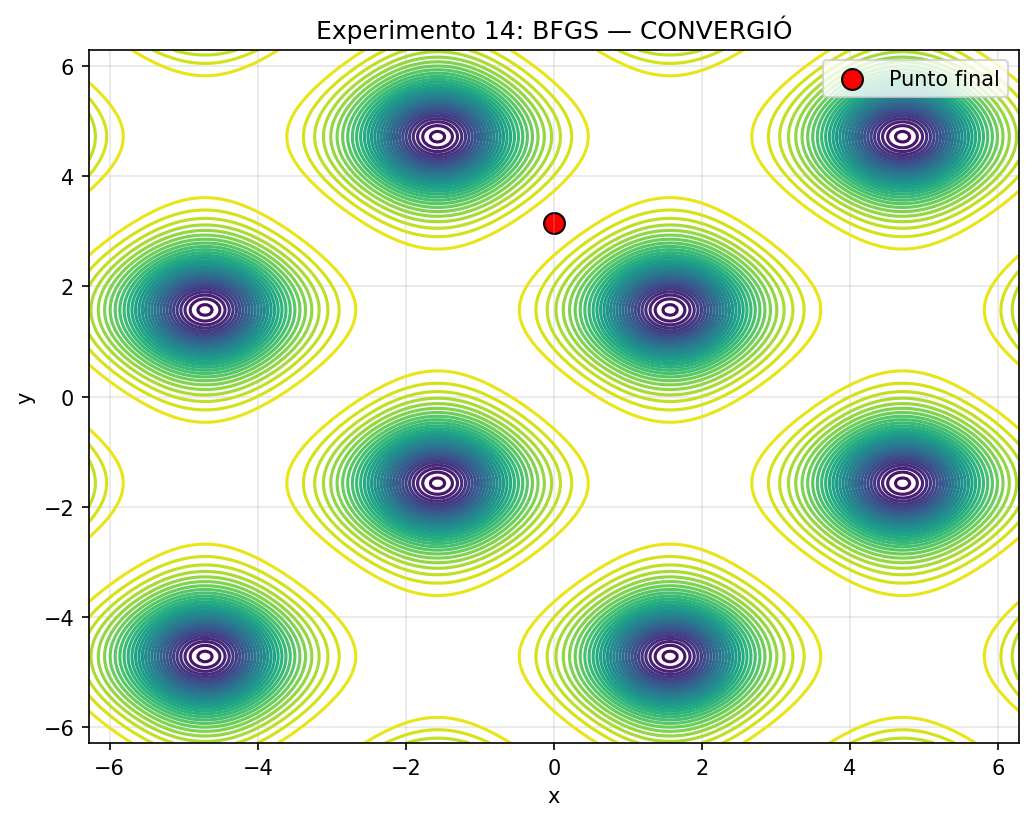

In [57]:
# Seleccionar el número de experimento a visualizar
numero_experimento = 14  # 👈 Cambia este número para ver diferentes experimentos (1-14)

# Verificar que el experimento existe
if numero_experimento in resultados:
    res = resultados[numero_experimento]
    
    # ===== MOSTRAR RESULTADOS ESCRITOS =====
    print("=" * 70)
    print(f"RESULTADOS DEL EXPERIMENTO {numero_experimento}")
    print("=" * 70)
    print(f"\nMétodo: {res['metodo']}")
    
    # Mostrar parámetros
    if res['metodo'] == "Newton Paso Fijo":
        print(f"Tamaño de paso (α): {res['parametros']['alpha']}")
    print(f"Punto inicial: {res['parametros']['x0']}")
    print(f"Tolerancia: {res['parametros']['tol']}")
    print(f"Máximo de iteraciones: {res['parametros']['max_iter']}")
    
    # Mostrar resultados
    estado = "✅ CONVERGIÓ" if res['resultado']['convergido'] else "❌ DIVERGIÓ"
    print(f"\nEstado: {estado}")
    print(f"Punto final: {res['resultado']['x_final']}")
    print(f"f(x*) = {res['resultado']['f_final']:.6f}")
    if(res['resultado']['iteraciones']==0 or res['resultado']['iteraciones']==100):
        print(f"Iteraciones realizadas: {res['resultado']['iteraciones']}")
    else :    
        print(f"Iteraciones realizadas: {res['resultado']['iteraciones']-1}")
    print(f"Norma del gradiente: {res['resultado']['norma_gradiente']:.6e}")
    print("=" * 70)
    
    # ===== MOSTRAR GRÁFICA =====
    from IPython.display import Image, display
    ruta_grafica = f'graficas/experimento_{numero_experimento}.png'
    
    if os.path.exists(ruta_grafica):
        display(Image(filename=ruta_grafica))
    else:
        print("\n⚠️ Gráfica no encontrada. Ejecuta la Sección 3 primero.")
else:
    print(f"❌ El experimento {numero_experimento} no existe.")
    print(f"Experimentos disponibles: {list(resultados.keys())}")